In [1]:
import pandas as pd
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ct = 'DG_Glut'
leg = [f"{ct}.{age}" for age in ['8wk','18mo']]
abc_dir = '/home/qzeng_salk_edu/project/240429_abc_atac/ABC.By.ATAC.RPM'

In [14]:
mouse_genes = pd.read_csv('gene_meta.csv', index_col =0)
gene_name_to_id = mouse_genes.set_index('gene_name')['geneID.1'].to_dict()
gene_id_to_name = mouse_genes.set_index('geneID.1')['gene_name'].to_dict()
gene_meta = pd.read_csv('/home/qzeng_salk_edu/project/240321_abc_score/use.mouse_genes.csv', index_col = 0)

In [5]:
diff_deg = pd.read_csv(f'Domain.Genes.Expression/{ct}/DiffExpress.DomainGene.csv', index_col = 0)
all_gene_ids = [gene_name_to_id[gene_name] for gene_name in diff_deg.index]
diff_deg.head()

,fc,fdr,log2(18mo/2mo),-log10(padj),gene_length,abs_log2(18mo/2mo)
gene,,,,,,
Ube2w,0.845443,4.154202e-31,-0.242221,30.381512,78699,0.242221
Jph1,0.825558,4.420055e-59,-0.276558,58.354572,133329,0.276558
Smap1,0.867411,6.713544e-21,-0.205212,20.173048,77471,0.205212
Kcnt2,0.819156,9.380503e-95,-0.287791,94.027774,365909,0.287791
B3galt2,0.751478,8.633750e-10,-0.412198,9.063801,13950,0.412198


## prepare input abd df

In [6]:
all_young_df = pd.read_csv(f"{abc_dir}/{ct}/{leg[0]}.abc_score.csv", index_col = 0)
all_old_df = pd.read_csv(f"{abc_dir}/{ct}/{leg[-1]}.abc_score.csv", index_col = 0)

In [7]:
all_young_df['gene_id'] = all_young_df.index.map(lambda x: x.split('-')[-1])
all_old_df['gene_id'] = all_old_df.index.map(lambda x: x.split('-')[-1])

In [8]:
young_cutoff = np.percentile(all_young_df['contact'], 90)
old_cutoff = np.percentile(all_old_df['contact'], 90)
young_cutoff, old_cutoff

(8.0, 8.0)

In [9]:
all_young_df = all_young_df[all_young_df['contact'] >= young_cutoff]
all_old_df = all_old_df[all_old_df['contact'] >= old_cutoff]

In [10]:
use_young_df = all_young_df[all_young_df['gene_id'].isin(all_gene_ids)]
use_old_df = all_old_df[all_old_df['gene_id'].isin(all_gene_ids)]

## select enhancer outside tad domain

In [27]:
tad_info = pd.read_csv(f'Domain.Genes.Expression/{ct}/All.Overlap.Domain.Genes.csv', index_col = 0)
tad_info['gene_id'] = tad_info['gene_name'].map(gene_name_to_id)
tad_info = tad_info.set_index('gene_id')
tad_info.head()

,gene_chr,gene_start,gene_end,gene_name,strand,gene_type,gene_length,chrom,tad_start,tad_end,8wk,9mo,18mo,18mo-8wk,celltype,start,end
gene_id,,,,,,,,,,,,,,,,,
ENSMUSG00000102275,chr1,4778063,4779212,Gm37144,-,TEC,1149,chr1,4775000,9575000,0.111111,0.125786,0.162823,0.051712,DG_Glut,9525000,9550000
ENSMUSG00000025903,chr1,4807788,4848410,Lypla1,+,protein_coding,40622,chr1,4775000,9575000,0.111111,0.125786,0.162823,0.051712,DG_Glut,9525000,9550000
ENSMUSG00000104217,chr1,4807892,4886770,Gm37988,+,protein_coding,78878,chr1,4775000,9575000,0.111111,0.125786,0.162823,0.051712,DG_Glut,9525000,9550000
ENSMUSG00000033813,chr1,4857814,4897909,Tcea1,+,protein_coding,40095,chr1,4775000,9575000,0.111111,0.125786,0.162823,0.051712,DG_Glut,9525000,9550000
ENSMUSG00000062588,chr1,4880049,4880651,Gm6104,-,processed_pseudogene,602,chr1,4775000,9575000,0.111111,0.125786,0.162823,0.051712,DG_Glut,9525000,9550000


In [35]:
def input_dist_info(df):
    df['enhancer_start'] = df.index.map(lambda x: int(x.split(':')[-1].split('-')[0]))
    df['gene_start'] = df['gene_id'].map(gene_meta['start'].to_dict())
    df['gene_end'] = df['gene_id'].map(gene_meta['end'].to_dict())
    
    df['eg_dist'] = np.minimum((df['gene_id'].map(gene_meta['start']) - df['enhancer_start']).abs(),
                                     (df['gene_id'].map(gene_meta['end']) - df['enhancer_start']).abs())
    df['tad_start'] = df['gene_id'].map(tad_info['tad_start'].to_dict())
    df['tad_end'] = df['gene_id'].map(tad_info['tad_end'].to_dict())
    return df

In [68]:
use_young_df = input_dist_info(use_young_df)
use_old_df = input_dist_info(use_old_df)

In [69]:
all_df = []
for gene_id, tmpdf in use_young_df.groupby('gene_id'):
    tmpdf['norm_abc_score'] = tmpdf['abc_score'] / tmpdf['abc_score'].sum()
    all_df.append(tmpdf)
use_young_df= pd.concat(all_df)

In [70]:
all_df = []
for gene_id, tmpdf in use_old_df.groupby('gene_id'):
    tmpdf['norm_abc_score'] = tmpdf['abc_score'] / tmpdf['abc_score'].sum()
    all_df.append(tmpdf)
use_old_df= pd.concat(all_df)

In [71]:
# use_young_df = use_young_df[(use_young_df['enhancer_start'] < use_young_df['tad_end']) & (use_young_df['enhancer_start'] > use_young_df['tad_start'])]
# use_old_df = use_old_df[(use_old_df['enhancer_start'] < use_old_df['tad_end']) & (use_old_df['enhancer_start'] > use_old_df['tad_start'])]

In [80]:
young_gene_abc_mean = use_young_df.groupby('gene_id')['norm_abc_score'].mean()
old_gene_abc_mean = use_old_df.groupby('gene_id')['norm_abc_score'].mean()

In [81]:
result =pd.concat([young_gene_abc_mean, old_gene_abc_mean], axis = 1)
result.columns = ['Young.ABC.Mean','Old.ABC.Mean']
result.index = [gene_id_to_name[gene_id] for gene_id in result.index]

In [82]:
norm_result = result.div(result.mean(axis = 1), axis = 0)
norm_result['log2_abc_fc'] = np.log2(norm_result['Old.ABC.Mean']/norm_result['Young.ABC.Mean'])
norm_result= pd.concat([diff_deg, norm_result], axis = 1)
norm_result.head()

,fc,fdr,log2(18mo/2mo),-log10(padj),gene_length,abs_log2(18mo/2mo),Young.ABC.Mean,Old.ABC.Mean,log2_abc_fc
Ube2w,0.845443,4.154202e-31,-0.242221,30.381512,78699,0.242221,1.007092,0.992908,-0.020464
Jph1,0.825558,4.420055e-59,-0.276558,58.354572,133329,0.276558,1.079208,0.920792,-0.229026
Smap1,0.867411,6.713544e-21,-0.205212,20.173048,77471,0.205212,1.057851,0.942149,-0.167110
Kcnt2,0.819156,9.380503e-95,-0.287791,94.027774,365909,0.287791,0.965517,1.034483,0.099536
B3galt2,0.751478,8.633750e-10,-0.412198,9.063801,13950,0.412198,1.194444,0.805556,-0.568284


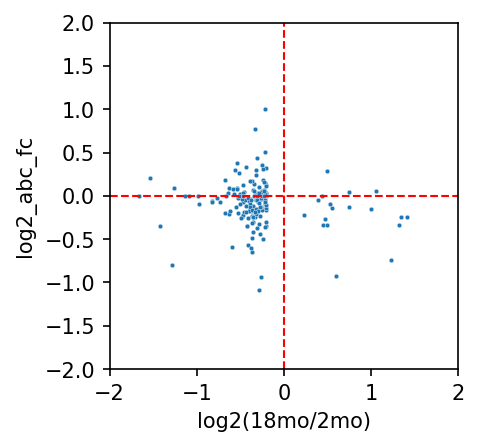

In [83]:
fig , ax = plt.subplots(figsize = (3,3), dpi = 150)
sns.scatterplot(data = norm_result,
                x = 'log2(18mo/2mo)',
                y = 'log2_abc_fc',
                ax = ax, 
                s = 5)
ax.set(xlim = (-2, 2), ylim  = (-2,2))
ax.axhline(y = 0, ls = '--', lw = 1, color="red")
ax.axvline(x = 0, ls = '--', lw = 1, color="red")
#ax.plot([-2, 2], [-2, 2], color="red", ls = '--', lw = 1)